# AutoMM for Image Segmentation

In [ ]:
!pip install autogluon.multimodal

In [ ]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/semantic_segmentation/leaf_disease_segmentation.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

Next, load the CSV files

In [ ]:
import pandas as pd
import os
dataset_path = os.path.join(download_dir, 'leaf_disease_segmentation')
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
val_data = pd.read_csv(f'{dataset_path}/val.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
image_col = 'image'
label_col = 'label'

In [ ]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

for per_col in [image_col, label_col]:
    train_data[per_col] = train_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    val_data[per_col] = val_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    test_data[per_col] = test_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))


print(train_data[image_col].iloc[1])
print(train_data[label_col].iloc[1])

/content/ag_automm_tutorial/leaf_disease_segmentation/train_images/00003.jpg
/content/ag_automm_tutorial/leaf_disease_segmentation/train_masks/00003.png


In [ ]:
train_data.head()

,image,label
0,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
1,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
2,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
3,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
4,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...


In [ ]:
!pip uninstall torch torchaudio -y

Found existing installation: torch 2.0.0+cu118
Uninstalling torch-2.0.0+cu118:
  Successfully uninstalled torch-2.0.0+cu118
Found existing installation: torchaudio 2.0.0+cu118
Uninstalling torchaudio-2.0.0+cu118:
  Successfully uninstalled torchaudio-2.0.0+cu118


In [ ]:
!pip install torch==2.0.0+cu118 torchaudio==2.0.0+cu118 torchvision==0.15.1+cu118 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.0.0%2Bcu118-cp310-cp310-linux_x86_64.whl (2267.3 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.0.0%2Bcu118-cp310-cp310-linux_x86_64.whl (4.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires torch<2.4,>=2.2, but you have torch 2.0.0+cu118 which is incompatible.
autogluon-multimodal 1.1.1 requires torchvision<0.19.0,>=0.16.0, but you have torchvision 0.15.1+cu118 which is incompatible.
pytorch-lightning 2.4.0 requires torch>=2.1.0, but you have torch 2.0.0+cu118 which is incompatible.


visualizing one image and its groundtruth mask.

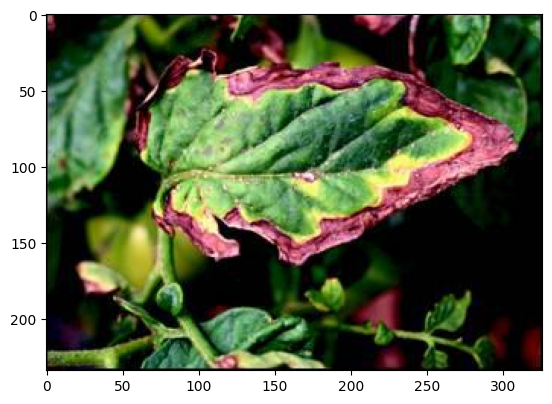

In [ ]:
from autogluon.multimodal.utils import SemanticSegmentationVisualizer
visualizer = SemanticSegmentationVisualizer()
visualizer.plot_image(test_data.iloc[1]['image'])

## Zero Shot Evaluation

In [ ]:
from autogluon.multimodal import MultiModalPredictor
predictor_zero_shot = MultiModalPredictor(
    problem_type="semantic_segmentation",
    label=label_col,
     hyperparameters={
            "model.sam.checkpoint_name": "facebook/sam-vit-base",
        },
    num_classes=1, # forground-background segmentation
)

In [ ]:
pred_zero_shot = predictor_zero_shot.predict({'image': [test_data.iloc[1]['image']]})

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

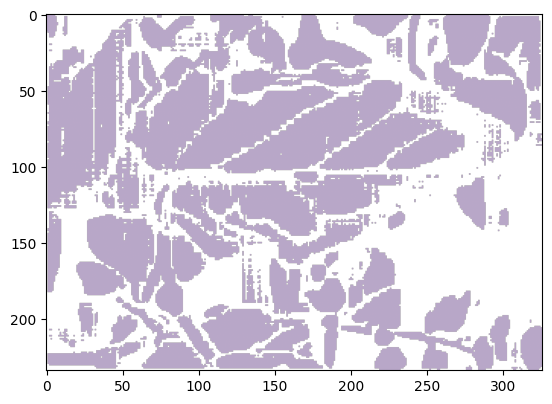

In [ ]:
visualizer.plot_mask(pred_zero_shot)

In [ ]:
scores = predictor_zero_shot.evaluate(test_data, metrics=["iou"])
print(scores)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

{'iou': 0.14016366004943848}


In [ ]:
from autogluon.multimodal import MultiModalPredictor
import uuid
save_path = f"./tmp/{uuid.uuid4().hex}-automm_semantic_seg"
predictor = MultiModalPredictor(
    problem_type="semantic_segmentation",
    label="label",
     hyperparameters={
            "model.sam.checkpoint_name": "facebook/sam-vit-base",
        },
    path=save_path,
)
predictor.fit(
    train_data=train_data,
    tuning_data=val_data,
    time_limit=180, # seconds
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
Pytorch Version:    2.0.0+cu118
CUDA Version:       11.8
Memory Avail:       76.83 GB / 83.48 GB (92.0%)
Disk Space Avail:   187.69 GB / 235.68 GB (79.6%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/tmp/66b9eaf7b42b40d79568843bc423372d-automm_semantic_seg
    ```

INFO: Seed set to 0
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
GPU Coun

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 100: 'val_iou' reached 0.53900 (best 0.53900), saving model to '/content/tmp/66b9eaf7b42b40d79568843bc423372d-automm_semantic_seg/epoch=0-step=100.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 200: 'val_iou' reached 0.59600 (best 0.59600), saving model to '/content/tmp/66b9eaf7b42b40d79568843bc423372d-automm_semantic_seg/epoch=1-step=200.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 300: 'val_iou' reached 0.64894 (best 0.64894), saving model to '/content/tmp/66b9eaf7b42b40d79568843bc423372d-automm_semantic_seg/epoch=2-step=300.ckpt' as top 3
INFO: Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/tmp/66b9eaf7b42b40d79568843bc423372d-automm_semantic_seg")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [ ]:
scores = predictor.evaluate(test_data, metrics=["iou"])
print(scores)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

{'iou': 0.6753678917884827}
